# Variable Discretization

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

**Discretization, or binning**, is the process of **transforming continuous variables into discrete
variables** by creating a set of contiguous intervals, also called bins, that span the range of
the variable values. Discretization is used to **change the distribution of skewed variables**
and to **minimize the influence of outliers**, and hence improve the performance of some
machine learning models.

In [2]:
boston = pd.read_csv("data/boston.csv")
boston.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

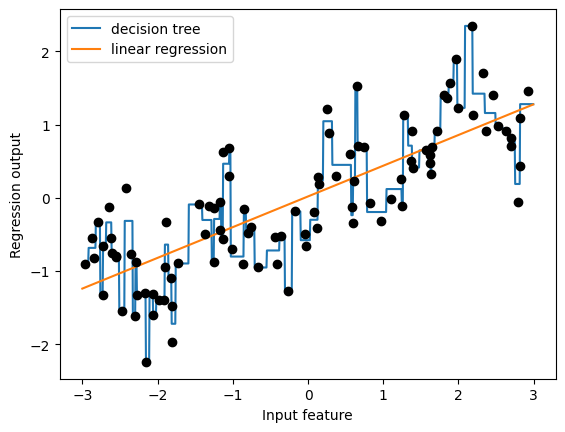

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from helpers.datasets import make_wave

X, y = make_wave(n_samples=100)

line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_split=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best")
plt.show()

Za linerne modele bomo podatke pripravili drugače kot npr. za drevesne modele. Drevesni modeli, lahko iščejo precej kompleksne vzorce, ki jih linerni ne morejo.

Iz tega razloga binning recimo bolj uproabljamo pri linearnih modelih.

## Dividing the variable into intervals of equal width

**In equal-width discretization, the variable values are sorted into intervals of the same
width.** 

    Width = (Max(X) - Min(X)) / Bins

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
data = boston.copy()

X_train, X_test, y_train, y_test = train_test_split(data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

Za ponazoritev prikazano kako bi to naredili v pandasu. V praki obstajajo vgrajene metode v skleran knjižnici.

In [31]:
# Let's calculate the range of the LSTAT variable, that is, the difference between its maximum and minimum values:
lstat_range = X_train['LSTAT'].max() - X_train['LSTAT'].min()

# Let's determine the interval width, which is the variable's value range divided by the number of bins:
inter_width = int(lstat_range / 10)

# Let's capture in new variables, the rounded minimum and maximum values of LSTAT:
min_value = int(np.floor( X_train['LSTAT'].min()))
max_value = int(np.ceil( X_train['LSTAT'].max()))

print(min_value, max_value, inter_width)

#Let's create a list with the interval limits using list comprehension and print out the limits:
intervals = [i for i in range(min_value, max_value + inter_width, inter_width)]
print(intervals)

# Let's discretize LSTAT and capture the discretized variable in a new column in the dataframe:
X_train['lstat_disc'] = pd.cut(x=X_train['LSTAT'], bins=intervals, include_lowest=True)

#Let's print the top 10 observations of the discretized and original variable, side by side:
print(X_train[['LSTAT', 'lstat_disc']].sample(10))

1 37 3
[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37]
     LSTAT    lstat_disc
285   8.23   (7.0, 10.0]
217   9.69   (7.0, 10.0]
243   5.19    (4.0, 7.0]
373  34.77  (34.0, 37.0]
499  15.10  (13.0, 16.0]
86   12.86  (10.0, 13.0]
365   7.12   (7.0, 10.0]
125  14.81  (13.0, 16.0]
209  23.09  (22.0, 25.0]
14   10.26  (10.0, 13.0]


In [32]:
# Let's calculate the number of observations per interval:
print(X_train.groupby('lstat_disc')['LSTAT'].count())

lstat_disc
(0.999, 4.0]    28
(4.0, 7.0]      67
(7.0, 10.0]     63
(10.0, 13.0]    49
(13.0, 16.0]    44
(16.0, 19.0]    45
(19.0, 22.0]    21
(22.0, 25.0]    17
(25.0, 28.0]     7
(28.0, 31.0]     9
(31.0, 34.0]     0
(34.0, 37.0]     4
Name: LSTAT, dtype: int64


In [33]:
# Now, let's discretize LSTAT in the test set using pandas' cut() method:
X_test['lstat_disc'] = pd.cut(x=X_test['LSTAT'], bins=intervals, include_lowest=True)

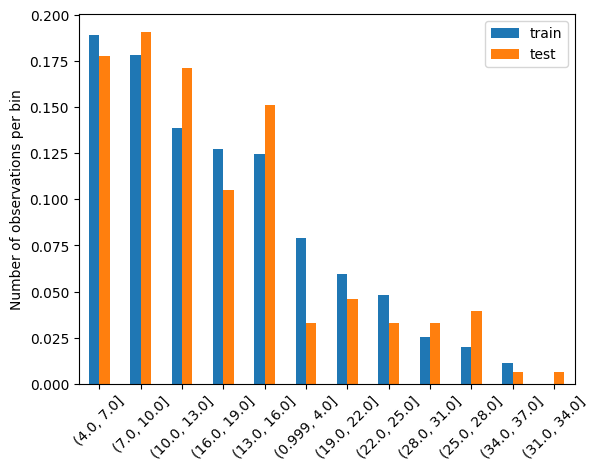

In [34]:
t1 = X_train['lstat_disc'].value_counts() / len(X_train)
t2 = X_test['lstat_disc'].value_counts() / len(X_test)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')
plt.show()

Prikazano kako diskretiziramo v sklearn-u

In [35]:
from sklearn.preprocessing import KBinsDiscretizer

data = boston.copy()

X_train, X_test, y_train, y_test = train_test_split(data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

# Let's create an equal-width discretizer with scikit-learn by setting its strategy to uniform:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform') #uniform - equal-width

In [36]:
disc.fit(X_train[['LSTAT', 'DIS', 'RM']])

KBinsDiscretizer(encode='ordinal', n_bins=10, strategy='uniform')

In [37]:
train_t = disc.transform(X_train[['LSTAT', 'DIS', 'RM']])
test_t = disc.transform(X_test[['LSTAT', 'DIS', 'RM']])

In [38]:
# We can inspect the bin boundaries learned by the transformer
disc.bin_edges_

array([array([ 1.73 ,  5.255,  8.78 , 12.305, 15.83 , 19.355, 22.88 , 26.405,
              29.93 , 33.455, 36.98 ])                                       ,
       array([ 1.1742 ,  2.26943,  3.36466,  4.45989,  5.55512,  6.65035,
               7.74558,  8.84081,  9.93604, 11.03127, 12.1265 ])         ,
       array([3.561 , 4.0829, 4.6048, 5.1267, 5.6486, 6.1705, 6.6924, 7.2143,
              7.7362, 8.2581, 8.78  ])                                       ],
      dtype=object)

- Equal Width doesn’t improve the value spread -> npr. ne popravi distribucije, da bi bila boljša za linearne modele
- It can handle outliers
- Can be combined with categorical encodings

In [41]:
train_t # vidimo da so značilke sedaj označene glede na index intervala

array([[9., 0., 2.],
       [1., 2., 5.],
       [4., 0., 5.],
       ...,
       [2., 1., 4.],
       [4., 4., 4.],
       [3., 1., 3.]])

## Sorting the variable values in intervals of equal frequency

- v vsakem intervalu naj bo isto število vzorcev (kvantili)
- ta pristop je uporaben, če želimo popraviti distribucijo
- strategy = 'quantile'
- **POMEMBNO**: vse delamo na train set in nato samo apliciramo (fitamo) na test set

In [42]:
data = boston.copy()

X_train, X_test, y_train, y_test = train_test_split(data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

In [43]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

disc.fit(X_train[['LSTAT', 'DIS', 'RM']])

train_t = disc.transform(X_train[['LSTAT', 'DIS', 'RM']])
test_t = disc.transform(X_test[['LSTAT', 'DIS', 'RM']])

In [44]:
disc.bin_edges_

array([array([ 1.73 ,  4.623,  6.202,  7.528,  9.5  , 11.16 , 13.26 , 15.565,
              18.06 , 22.453, 36.98 ])                                       ,
       array([ 1.1742 ,  1.66132,  1.9793 ,  2.26121,  2.64774,  3.2157 ,
               3.7965 ,  4.45352,  5.40702,  6.8147 , 12.1265 ])         ,
       array([3.561 , 5.5783, 5.8532, 5.9628, 6.1048, 6.2155, 6.3946, 6.5632,
              6.794 , 7.185 , 8.78  ])                                       ],
      dtype=object)

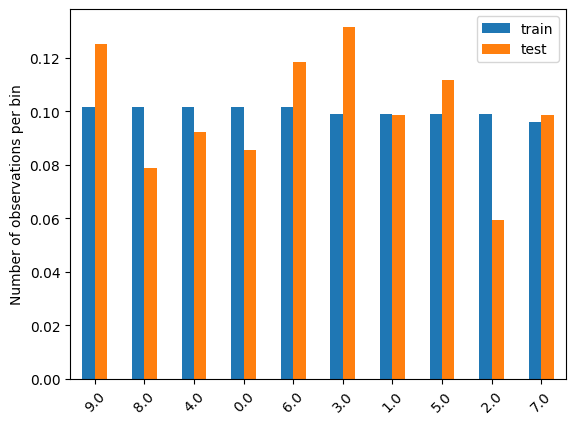

In [45]:
X_train = pd.DataFrame(train_t, columns =['LSTAT', 'DIS', 'RM'])
X_test = pd.DataFrame(test_t, columns =['LSTAT', 'DIS', 'RM'])
t1 = X_train['LSTAT'].value_counts() / len(X_train)
t2 = X_test['LSTAT'].value_counts() / len(X_test)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')
plt.show()

- Equal Frequency does improve the value spread
- It can handle outliers
- Can be combined with categorical encoding

## Performing discretization followed by categorical encoding
- encode='onehot' -> rezultat je v sparse matrix classu
- encode='onehot-dense' -> samo za izpis da vidimo kot matriko

In [46]:
data = boston.copy()

X_train, X_test, y_train, y_test = train_test_split(data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

In [51]:
disc = KBinsDiscretizer(n_bins=10, encode='onehot', strategy='quantile') # encode='onehot-dense'

disc.fit(X_train[['LSTAT', 'DIS', 'RM']])

train_t = disc.transform(X_train[['LSTAT', 'DIS', 'RM']])
test_t = disc.transform(X_test[['LSTAT', 'DIS', 'RM']])

In [52]:
disc.bin_edges_

array([array([ 1.73 ,  4.623,  6.202,  7.528,  9.5  , 11.16 , 13.26 , 15.565,
              18.06 , 22.453, 36.98 ])                                       ,
       array([ 1.1742 ,  1.66132,  1.9793 ,  2.26121,  2.64774,  3.2157 ,
               3.7965 ,  4.45352,  5.40702,  6.8147 , 12.1265 ])         ,
       array([3.561 , 5.5783, 5.8532, 5.9628, 6.1048, 6.2155, 6.3946, 6.5632,
              6.794 , 7.185 , 8.78  ])                                       ],
      dtype=object)

In [54]:
train_t
# sparse matrix je optimalnejse hranjenje tovrstnih matrik, kot da bi direktno v np ali df hranili
# ce zelimo videti izpis uporabimo encode='onehot-dense' encodiranje

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Allocating the variable values in arbitrary intervals
- ročno podamo intervale za bine (omogoča manual nastavitev intervalov)

In [55]:
data = boston.copy()

X_train, X_test, y_train, y_test = train_test_split(data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

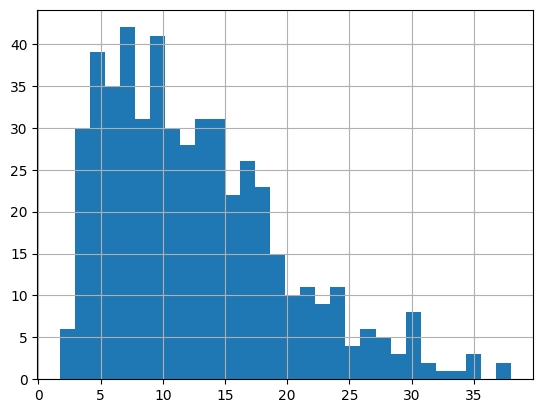

In [56]:
data['LSTAT'].hist(bins=30)
plt.show()

In [57]:
# Let's create a list with the arbitrary interval limits, setting the upper limit to infinity to accommodate bigger values:
intervals = [0, 10, 20, 30, np.Inf]

# Let's create a list with the interval limits as labels, that is, strings:
labels = ['0-10', '10-20', '20-30', '>30']

# Let's discretize the LSTAT variable
data['lstat_labels'] = pd.cut(data['LSTAT'], bins=intervals, labels=labels, include_lowest=True)
data['lstat_intervals'] = pd.cut(data['LSTAT'], bins=intervals, labels=None, include_lowest=True)

data[['LSTAT','lstat_labels', 'lstat_intervals']].head(10)

LSTAT lstat_labels lstat_intervals
0   4.98         0-10  (-0.001, 10.0]
1   9.14         0-10  (-0.001, 10.0]
2   4.03         0-10  (-0.001, 10.0]
3   2.94         0-10  (-0.001, 10.0]
4   5.33         0-10  (-0.001, 10.0]
5   5.21         0-10  (-0.001, 10.0]
6  12.43        10-20    (10.0, 20.0]
7  19.15        10-20    (10.0, 20.0]
8  29.93        20-30    (20.0, 30.0]
9  17.10        10-20    (10.0, 20.0]

In [58]:
data['lstat_intervals'].value_counts()

(-0.001, 10.0]    219
(10.0, 20.0]      213
(20.0, 30.0]       62
(30.0, inf]        12
Name: lstat_intervals, dtype: int64

metode za poenostavljanje - preprečiti overfitting (glej za nazaj)
- sklairanje
- transformacije znacilk
- prunning (pri drevesih)
- diskrezizacija

## Using decision trees for discretization
- kombiniramo
    - 1. uporabimo drevesni model
    - 2. rezultat modela je lineariziran -> uporabimo linearni model

In [59]:
from sklearn.tree import DecisionTreeRegressor

data = boston.copy()

X_train, X_test, y_train, y_test = train_test_split(data.drop('MEDV', axis=1), data['MEDV'], test_size=0.3, random_state=0)

# Let's assemble a decision tree to predict the MEDV target, setting the maximum depth to 3 and random_state for reproducibility
tree_model = DecisionTreeRegressor(max_depth=3, random_state=0)

# Let's fit the decision tree using the LSTAT variable to predict the MEDV target
tree_model.fit(X_train['LSTAT'].to_frame(), y_train)

X_train['lstat_tree'] = tree_model.predict(X_train['LSTAT'].to_frame())

# Let's explore the end leaves, that is, bins, the tree created:
X_train['lstat_tree'].unique()

array([12.91724138, 27.15384615, 16.36181818, 32.04285714, 20.555     ,
       34.88333333, 23.71388889, 41.80740741])

In [60]:
# Let's now discretize the LSTAT variable in the test set:
X_test['lstat_tree'] = tree_model.predict(X_test['LSTAT'].to_frame())

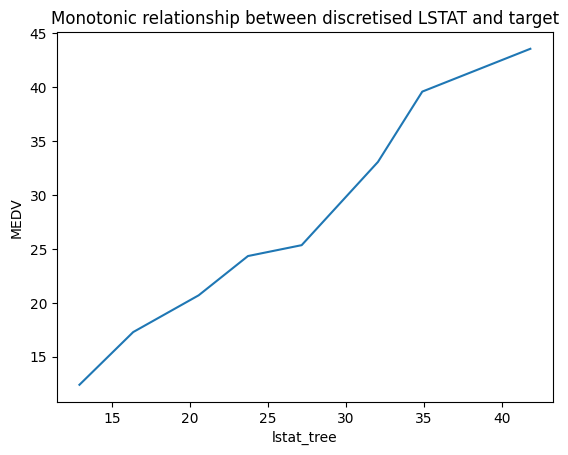

In [61]:
pd.concat([X_test, y_test],axis=1).groupby(['lstat_tree'])['MEDV'].mean().plot()
plt.title('Monotonic relationship between discretised LSTAT and target')
plt.ylabel('MEDV')
plt.show()

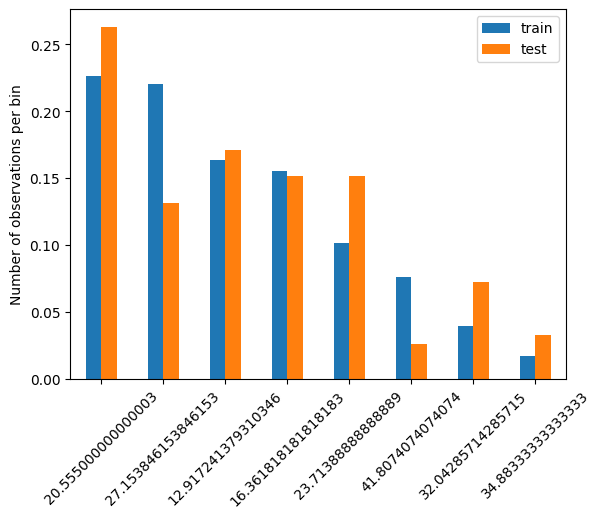

In [62]:
t1 = X_train['lstat_tree'].value_counts() / len(X_train)
t2 = X_test['lstat_tree'].value_counts() / len(X_test)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')
plt.show()

vgrajena diskretizacija z drevesmo v feature-engine knjižnico

In [64]:
from feature_engine.discretisation import DecisionTreeDiscretiser

treeDisc = DecisionTreeDiscretiser(cv=10, 
                                   scoring='neg_mean_squared_error',
                                   variables=['LSTAT', 'RM', 'DIS'], # katere značilke diskretiziramo
                                   regression=True, 
                                   param_grid={'max_depth': [1,2,3,4]}) # poskusi več globin

treeDisc.fit(X_train, y_train)
treeDisc.binner_dict_['LSTAT'].best_params_

{'max_depth': 3}

In [65]:
train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

- Decision Tree does not improve the value spread
- It can handle outliers well as trees are robust to outliers.
- Creates monotonic relationships

## Example: Wave regression dataset 

In [66]:
from sklearn.preprocessing import KBinsDiscretizer

In [67]:
X, y = make_wave(n_samples=100)

kb = KBinsDiscretizer(n_bins=10, strategy='uniform')
kb.fit(X)
print("bin edges: \n", kb.bin_edges_)

bin edges: 
 [array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
        -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
         2.92132162])                                                   ]


In [68]:
X_binned = kb.transform(X)
X_binned

<100x10 sparse matrix of type '<class 'numpy.float64'>'
	with 100 stored elements in Compressed Sparse Row format>

In [69]:
print(X[:10])
X_binned.toarray()[:10]

[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]
 [-2.06403288]
 [-2.65149833]
 [ 2.19705687]
 [ 0.60669007]
 [ 1.24843547]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [70]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)

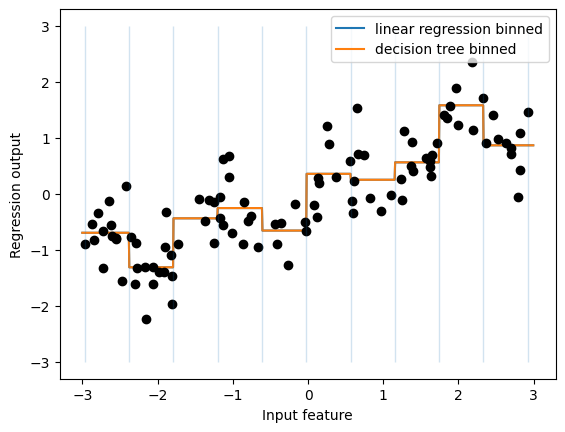

In [71]:
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.show()

- Binnin je dober za linearno regresijo. Značilke transformira na ta način, da je uporaba linearnega ML modela uspešnejša.
- Za drevesne modele se ga ne priporoča, saj njihova robustnost omogoča, da gledajo več značilk hkrati. Težava pri drevesih je, da časovna kompleksnot pri velikem številu značilk zelo naraste.